In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import islice

In [57]:
data = pd.read_csv('./datasets/WASSA23_essay_level_train_preproc.tsv', sep='\t') # internal train + internal val
#data = pd.read_csv('./datasets/WASSA23_essay_level_internal_train_preproc.tsv', sep='\t') # internal train

In [58]:
data

,empathy,distress,essay,emotion,gender,education,race,age,income,personality_conscientiousness,...,distress_count,prompt_bio,prompt_emp,prompt_emo,conversation_id,article_id,speaker_id,speaker_number,split,prompt
0,5.667000,4.375,it is really diheartening to read about these ...,sadness,1.0,4.0,1.0,33.0,50000.0,6.00,...,3.199801,An essay written by a 33.0 years old white mal...,The essay expresses high empathy and medium di...,The top emotions expressed in the essay are: ...,NaN,NaN,NaN,NaN,NaN,NaN
1,4.833000,4.875,the phone lines from the suicide prevention li...,sadness,1.0,4.0,1.0,33.0,50000.0,6.00,...,2.715752,An essay written by a 33.0 years old white mal...,The essay expresses medium empathy and medium ...,The top emotions expressed in the essay are: ...,NaN,NaN,NaN,NaN,NaN,NaN
2,5.333000,3.500,"no matter what your heritage, you should be ab...",neutral,1.0,4.0,1.0,33.0,50000.0,6.00,...,2.954012,An essay written by a 33.0 years old white mal...,The essay expresses high empathy and medium di...,The top emotions expressed in the essay are: ...,NaN,NaN,NaN,NaN,NaN,NaN
3,4.167000,5.250,it is frightening to learn about all these sha...,fear,1.0,4.0,1.0,33.0,50000.0,6.00,...,3.035200,An essay written by a 33.0 years old white mal...,The essay expresses medium empathy and high di...,The top emotions expressed in the essay are: ...,NaN,NaN,NaN,NaN,NaN,NaN
4,5.333000,4.625,the eldest generation of russians aren't being...,sadness,1.0,4.0,1.0,33.0,50000.0,6.00,...,2.945490,An essay written by a 33.0 years old white mal...,The essay expresses high empathy and medium di...,The top emotions expressed in the essay are: ...,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2432,1.000000,1.625,"After reading the article, i felt really alarm...",fear/hope,1.0,6.0,1.0,29.0,85000.0,6.75,...,2.804874,"An essay written by a 29 years old white male,...",The essay expresses low empathy and low distre...,The top emotions expressed in the essay are: ...,430.0,397.0,17.0,1.0,train,"After reading the article, i felt really alarm..."
2433,2.500000,1.500,It's very difficult to fathom living somewhere...,joy/sadness,2.0,7.0,1.0,38.0,42000.0,7.00,...,2.915323,An essay written by a 38 years old white femal...,The essay expresses low empathy and low distre...,The top emotions expressed in the essay are: ...,374.0,367.0,24.0,1.0,train,It's very difficult to fathom living somewhere...
2434,3.166667,2.750,it's crazy how islamic terrorism is still a th...,anger/surprise,1.0,6.0,1.0,34.0,68000.0,5.50,...,2.713512,"An essay written by a 34 years old white male,...",The essay expresses medium empathy and low dis...,The top emotions expressed in the essay are: ...,260.0,174.0,46.0,2.0,train,it's crazy how islamic terrorism is still a th...
2435,6.666667,6.375,Humans are the most selfish and wicked of all ...,disgust/neutral,1.0,7.0,1.0,28.0,165000.0,6.25,...,3.028520,"An essay written by a 28 years old white male,...",The essay expresses high empathy and high dist...,The top emotions expressed in the essay are: ...,98.0,57.0,40.0,2.0,train,Humans are the most selfish and wicked of all ...


In [40]:
emotions = []
for perceived_emotion in data['emotion'].unique():
	for emotion in perceived_emotion.split('/'):
		if emotion not in emotions:
			emotions.append(emotion)
for emotion in emotions:
	data[emotion] = data["emotion"].str.lower().str.contains(emotion).astype(int)

In [41]:
def plot_emotions_distribution(data):
	_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

	data['emotion'].value_counts().plot(
		kind='bar',
		xlabel='Emotion',
		ylabel='Number of essays',
		ax=ax1
	)

	data[emotions].sum().sort_values(ascending=False).plot(
		kind='bar',
		xlabel='Emotion',
		ylabel='Number of essays',
		ax=ax2
		)

	plt.plot()

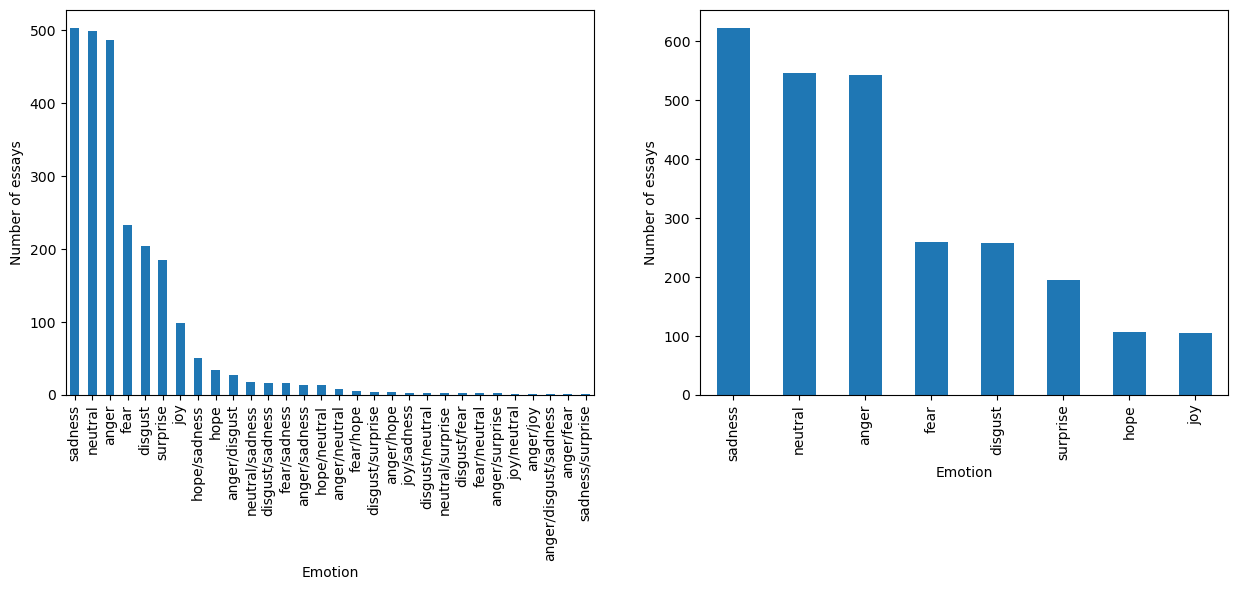

In [42]:
plot_emotions_distribution(data)

In [59]:
proportion = {}
for emotion in emotions:
    proportion[emotion] = data[emotion].sum() / data.shape[0]
proportion

{'sadness': 0.2244562987279442,
 'neutral': 0.20311858842839556,
 'fear': 0.10258514567090685,
 'anger': 0.212556421830119,
 'disgust': 0.09684037751333607,
 'surprise': 0.07755437012720558,
 'joy': 0.04185473943373,
 'hope': 0.04103405826836274}

In [85]:
def downsample_to_proportion(rows, proportion, tot_samples):
    n_samples = int(tot_samples * proportion)
    new_rows = pd.DataFrame()
    index_list = []
    count = 0
    
    for idx, row in rows.iterrows():
        if idx not in index_list:
            index_list.append(idx)
            new_rows = new_rows.append(row)
            count += 1
        if count == n_samples:
            break
    return new_rows

In [91]:
for emotion_dataset, prop in proportion.items():
    new_data = pd.DataFrame()

    for emotion, emotion_proportion in proportion.items():
        if emotion != emotion_dataset:
            dataset_emotion = data.groupby('emotion').get_group(emotion)
            new_data_emotions = dataset_emotion.groupby('emotion').apply(downsample_to_proportion, 
                                                                         proportion=emotion_proportion, 
                                                                         tot_samples=100)
            new_data = pd.concat([new_data, new_data_emotions])
    
    new_data['emotion_dataset'] = '0'
    dataset_current_emotion = data.groupby('emotion').get_group(emotion_dataset)
    dataset_current_emotion['emotion_dataset'] = '1'
    new_data = pd.concat([new_data, dataset_current_emotion])
    new_data = new_data.sample(frac=1).reset_index(drop=True)
    new_data.to_csv(f'./dataset_split/WASSA23_essay_level_train_preproc_downsampled_{emotion_dataset}.tsv', sep='\t', index=False)

C:\Users\giuli\AppData\Local\Temp\ipykernel_11028\2694037185.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_rows = new_rows.append(row)
C:\Users\giuli\AppData\Local\Temp\ipykernel_11028\2694037185.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_rows = new_rows.append(row)
C:\Users\giuli\AppData\Local\Temp\ipykernel_11028\2694037185.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_rows = new_rows.append(row)
C:\Users\giuli\AppData\Local\Temp\ipykernel_11028\2694037185.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_rows = new_rows.append(row)
C:\Users\giuli\AppData\Local\Temp\ipykernel_11028\2694037185

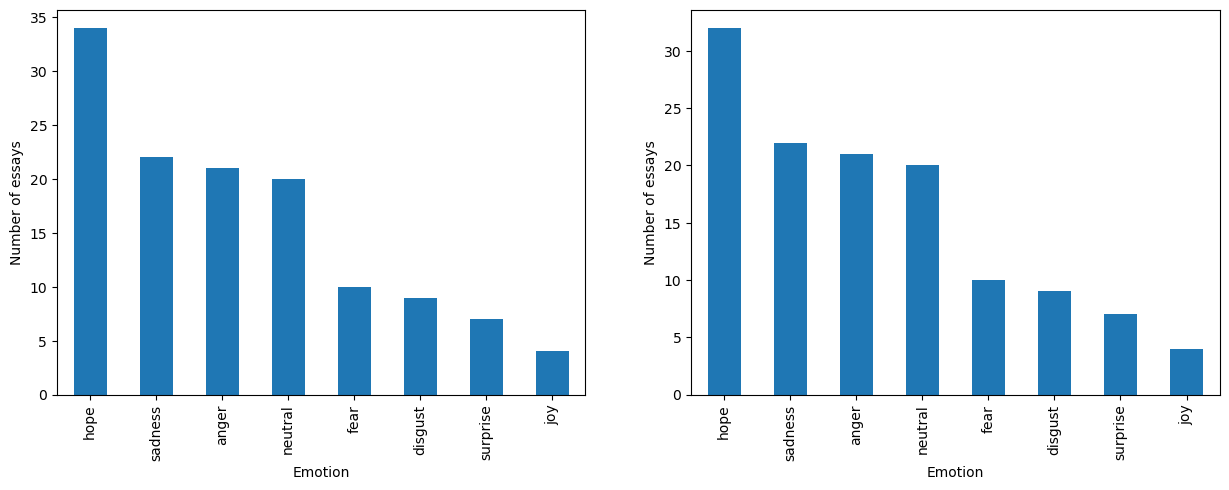

In [92]:
plot_emotions_distribution(new_data)